In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
m = pd.read_csv('../dataset/stack-matrix.csv', index_col='filename').to_numpy()
pg_total = m[:, 0].sum()
optimal_total = np.min(m, axis=1).sum()
print('pg_total:', pg_total)
print('optimal_total:', optimal_total)

pg_p90 = np.percentile(m[:, 0], 90)
optimal_p90 = np.percentile(np.min(m, axis=1), 90)
print('pg_p90:', pg_p90)
print('optimal_p90:', optimal_p90)

pg_total: 5272.4370493888855
optimal_total: 3942.0963950157166
pg_p90: 1.7624027729034424
optimal_p90: 1.5964620113372805


In [3]:
def get_data(filename):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"] / 3600)
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] / 3600 - pg_total / 3600)
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
            if "mse" in result:
                mse.append(result["mse"])
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    pg_total_hour = pg_total / 3600
    df = pd.DataFrame({
        "total_latency": total_latency,
        "improvement": (pg_total_hour - total_latency) / pg_total_hour,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time,
    })
    df['overhead_time'] = df['training_time'] + df['inference_time']
    df['overhead_time_cdf'] = df['overhead_time'].cumsum()
    
    if len(mse) > 0:
        df["mse"] = mse
    
    return df

In [4]:
def combine_plot(p_mc_lists, mc_lists):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    
    x_combined = np.linspace(start, end, 5000)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    p25 = np.percentile(fi_list, 25, axis=0)
    p75 = np.percentile(fi_list, 75, axis=0)
    
    return x_combined, y_combined, std, p25, p75

def get_y(x, y, std, p25,p75, x_target):
    x_ = x[x > x_target * 0.99]
    x_ = x_[x_ < x_target * 1.01]
    x_ = x_[len(x_)//2]
    x_index = x.tolist().index(x_)
    return x_, y[x_index], std[x_index], p25[x_index], p75[x_index]

def get_multiple(path, x_name, y_name, n=20):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i))
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x, y, std, p25, p75  = combine_plot(x_list, y_list)
    
    checkpoint_list = [0.375, 0.75, 1.5, 3, 6]

    l = []
    try:
        for checkpoint in checkpoint_list:
            l.append(get_y(x, y, std, p25, p75, checkpoint))
    except:
        pass
        
    return x, y, std, l

In [5]:
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize=16.5
label_fontsize=20
title_fontsize=20
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6",
    "#d47628", 
    "#8fb943",
    "#d15c6b",
    "#8481ba",
    "#413123",
    "#ffdb58",
    "#a5a5a5",
    "#acbfea",
]

line_styles = ['-', '--', '-.', ':']

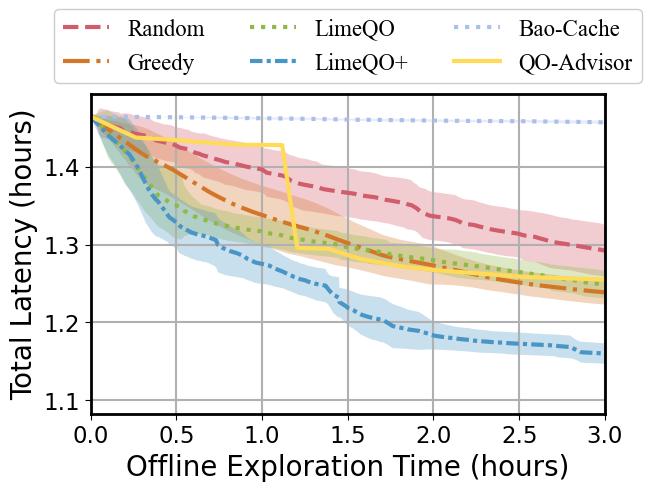

In [6]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

x, y, std, random = get_multiple("../experiment/stack/random/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[3], label='Random', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std, greedy = get_multiple("../experiment/stack/greedy/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[1], label='Greedy', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[1], linewidth=0)

x, y, std, limeqo = get_multiple("../experiment/stack/limeqo/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='LimeQO', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

x, y, std, limeqo_embd = get_multiple("../experiment/stack/limeqo+/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[0], label='LimeQO+', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

# x, y, std, datashift = get_multiple("../experiment/stack-datashift/stack_{}.json", "execution_time", "total_latency", n=5)
# ax.plot(x, y, color = color_scheme[4], label='LimeQO-Datashift', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[4], linewidth=0)

x, y, std, bao_cache = get_multiple("../experiment/stack/bao_cache/stack_bao_cache_{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[8], label='Bao-Cache', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[8], linewidth=0)


df = get_data("../experiment/stack/qo_advisor/1.json")
ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[6], label='QO-Advisor', linestyle=line_styles[0],  linewidth=linewidth)
f = interp1d(df["execution_time"], df["total_latency"], kind='linear', fill_value="extrapolate")
checkpoint_list = [0.375, 0.75, 1.5, 3, 6]
qo_advisor = [f(checkpoint) for checkpoint in checkpoint_list]

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_xlim(0, 3)
# ax.set_ylim(1.25, 1.5)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

plt.savefig('../fig/stack.pdf', bbox_inches='tight')

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_379/2401809565.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+labels)


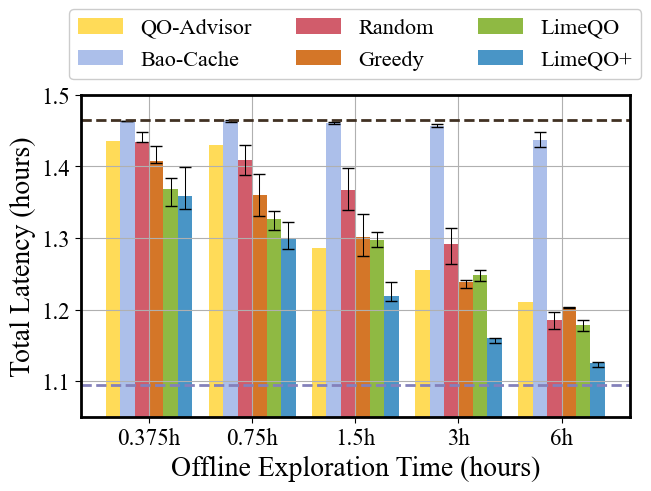

In [7]:
labels = ['0.375h','0.75h', '1.5h', '3h', '6h']
lines = []
line = ['Random', 'Greedy', 'LimeQO', 'LimeQO+', 'QO-Advisor']
lines.append(','.join(line))
for i in range(5):
    line = [labels[i], random[i][1], greedy[i][1], limeqo[i][1], limeqo_embd[i][1]]
    line = ','.join([str(x) for x in line])
    lines.append(line)

with open('../result/stack.csv', "w") as f:
    f.write('\n'.join(lines))
    
    
fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)

x = np.arange(len(labels))
width = 0.14
# draw bar with error bar

ax.bar(x - 2.5 * width, qo_advisor, width, label='QO-Advisor', color=color_scheme[6])
ax.bar(x - 1.5 * width, [bao_cache[i][1] for i in range(len(labels))], width, label='Bao-Cache', color=color_scheme[8], yerr=[[bao_cache[i][2] for i in range(len(labels))], [bao_cache[i][2] for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x - 0.5 * width, [random[i][1] for i in range(len(labels))], width, label='Random', color=color_scheme[3], yerr=[[random[i][1] - random[i][3] for i in range(len(labels))],[random[i][4] - random[i][1] for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x + 0.5 * width, [greedy[i][1] for i in range(len(labels))], width, label='Greedy', color=color_scheme[1], yerr=[[greedy[i][1] - greedy[i][3] for i in range(len(labels))],[greedy[i][4] - greedy[i][1] for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x + 1.5 * width, [limeqo[i][1] for i in range(len(labels))], width, label='LimeQO', color=color_scheme[2], yerr=[[limeqo[i][1] - limeqo[i][3] for i in range(len(labels))],[limeqo[i][4] - limeqo[i][1] for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x + 2.5 * width, [limeqo_embd[i][1] for i in range(len(labels))], width, label='LimeQO+', color=color_scheme[0], yerr=[[max(0,limeqo_embd[i][1] - limeqo_embd[i][3]) for i in range(len(labels))],[max(0,limeqo_embd[i][4] - limeqo_embd[i][1]) for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=2) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=2) # Optimal

ax.set_xticklabels([0]+labels)
ax.set_ylim(1.05, 1.5)
# ax.set_yticks([0, 30, 60, 90, 120, 150, 180])
ax.grid('--')
ax.legend(framealpha=1,fontsize=16, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)

fig.savefig('../fig/stack_bar.pdf', bbox_inches='tight')

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_379/1293913752.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+labels)


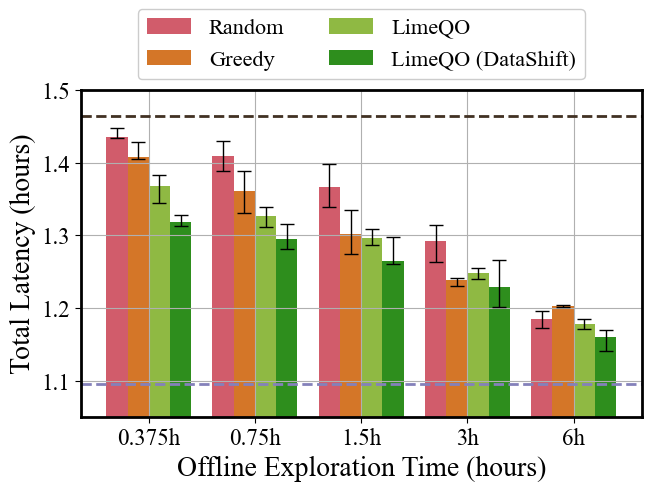

In [8]:
x, y, std, datashift = get_multiple("../experiment/stack-datashift/stack_{}.json", "execution_time", "total_latency", n=5)

labels = ['0.375h','0.75h', '1.5h', '3h', '6h']
lines = []
line = ['Random', 'Greedy', 'LimeQO', 'LimeQO (Datashift)']
lines.append(','.join(line))
for i in range(5):
    line = [labels[i], random[i][1], greedy[i][1], limeqo[i][1], datashift[i][1]]
    line = ','.join([str(x) for x in line])
    lines.append(line)

with open('../result/stack.csv', "w") as f:
    f.write('\n'.join(lines))
    
    
fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)

x = np.arange(len(labels))
width = 0.2
# draw bar with error bar

ax.bar(x - 1.5 * width, [random[i][1] for i in range(5)], width, label='Random', color=color_scheme[3], yerr=[[random[i][1] - random[i][3] for i in range(5)],[random[i][4] - random[i][1] for i in range(5)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
ax.bar(x - 0.5 * width, [greedy[i][1] for i in range(5)], width, label='Greedy', color=color_scheme[1], yerr=[[greedy[i][1] - greedy[i][3] for i in range(5)],[greedy[i][4] - greedy[i][1] for i in range(5)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
ax.bar(x + 0.5 * width, [limeqo[i][1] for i in range(5)], width, label='LimeQO', color=color_scheme[2], yerr=[[limeqo[i][1] - limeqo[i][3] for i in range(5)],[limeqo[i][4] - limeqo[i][1] for i in range(5)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
ax.bar(x + 1.5 * width, [datashift[i][1] for i in range(5)], width, label='LimeQO (DataShift)', color='#2E8E1D', yerr=[[datashift[i][1] - datashift[i][3] for i in range(5)],[datashift[i][4] - datashift[i][1] for i in range(5)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=2) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=2) # Optimal

ax.set_xticklabels([0]+labels)
ax.set_ylim(1.05, 1.5)
# ax.set_yticks([0, 30, 60, 90, 120, 150, 180])
ax.grid('--')
ax.legend(framealpha=1,fontsize=16, loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.28))
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)

fig.savefig('../fig/datashift.pdf', bbox_inches='tight')

In [9]:
def get_data(filename):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"] / 3600)
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] / 3600 - (pg_total + 576.502233) / 3600)
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
            if "mse" in result:
                mse.append(result["mse"])
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    pg_total_hour = pg_total / 3600
    df = pd.DataFrame({
        "total_latency": total_latency,
        "improvement": (pg_total_hour - total_latency) / pg_total_hour,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time,
    })
    df['overhead_time'] = df['training_time'] + df['inference_time']
    df['overhead_time_cdf'] = df['overhead_time'].cumsum()
    
    if len(mse) > 0:
        df["mse"] = mse
    
    return df

In [10]:
def combine_plot(p_mc_lists, mc_lists):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    
    x_combined = np.linspace(start, end, 5000)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    median = np.median(fi_list, axis=0)
    p25 = np.percentile(fi_list, 25, axis=0)
    p75 = np.percentile(fi_list, 75, axis=0)
    
    return x_combined, y_combined, std, median, p25, p75

def get_y(x, y, std, p25,p75, x_target):
    x_ = x[x > x_target * 0.99]
    x_ = x_[x_ < x_target * 1.01]
    x_ = x_[len(x_)//2]
    x_index = x.tolist().index(x_)
    return x_, y[x_index], std[x_index], p25[x_index], p75[x_index]

def get_multiple(path, x_name, y_name, n=20):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i))
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x, y, std, median, p25, p75  = combine_plot(x_list, y_list)
    
    checkpoint_list = [0.5, 0.75, 1, 1.25, 1.5]
    l = []
    for checkpoint in checkpoint_list:
        l.append(get_y(x, y, std, p25, p75, checkpoint))
        
    return x, y, std, median, p25, p75, l

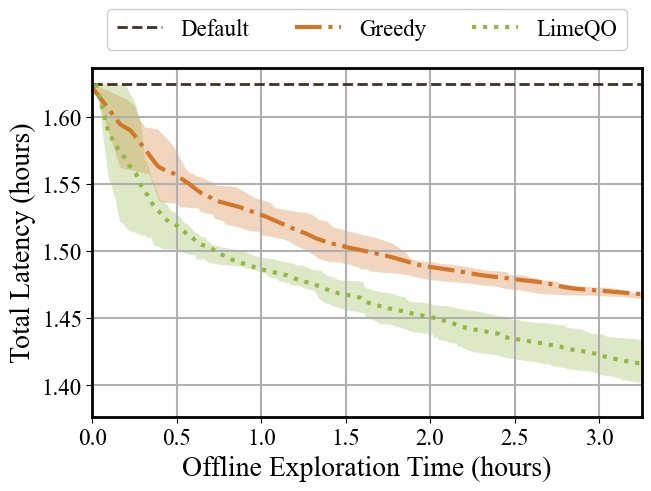

In [11]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

ax.axhline((pg_total+576.502233)/3600, color = color_scheme[5], label='Default', linestyle=line_styles[1], linewidth=2) # PG


x, y, std, median, p25, p75, gr = get_multiple("../experiment/stack/greedy_test_{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[1], label='Greedy', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, p25, p75, alpha=0.3, color = color_scheme[1], linewidth=0)

x, y, std, median, p25, p75, li = get_multiple("../experiment/stack/greedy_lime_{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='LimeQO', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, p25, p75, alpha=0.3, color = color_scheme[2], linewidth=0)



ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.2))
ax.grid('--')
ax.set_xlim(0, 3.25)
# ax.set_ylim(1.45, 1.65)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

plt.savefig('../fig/greedy.pdf', bbox_inches='tight')

In [12]:
# labels = [0.5, 0.75, 1, 1.25, 1.5]
# lines = []
# line = ['Greedy', 'LimeQO']
# lines.append(','.join(line))
# for i in range(len(labels)):
#     line = [labels[i], gr[i][1], li[i][1]]
#     line = ','.join([str(x) for x in line])
#     lines.append(line)

# with open('../result/stack.csv', "w") as f:
#     f.write('\n'.join(lines))
    
    
# fig, ax = plt.subplots(1,1,constrained_layout=True)
# ax.spines['bottom'].set_linewidth(bwith)
# ax.spines['left'].set_linewidth(bwith)
# ax.spines['top'].set_linewidth(bwith)
# ax.spines['right'].set_linewidth(bwith)
# ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
# ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)

# x = np.arange(len(labels))
# width = 0.2
# # draw bar with error bar

# ax.bar(x - 0.5 * width, [gr[i][1] for i in range(5)], width, label='Greedy', color=color_scheme[1], yerr=[[gr[i][1] - gr[i][3] for i in range(5)],[gr[i][4] - gr[i][1] for i in range(5)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
# ax.bar(x + 0.5 * width, [li[i][1] for i in range(5)], width, label='LimeQO', color=color_scheme[2], yerr=[[li[i][1] - li[i][3] for i in range(5)],[li[i][4] - li[i][1] for i in range(5)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})

# ax.axhline((pg_total+576.502233)/3600, color = color_scheme[5], label='Default', linestyle=line_styles[1], linewidth=2) # PG
# # ax.axhline(optimal_total/3600, color = color_scheme[4], label='Optimal',linestyle=line_styles[1], linewidth=2) # Optimal

# ax.set_xticklabels([0]+labels)
# ax.set_ylim(1.45, 1.65)
# # ax.set_yticks([0, 30, 60, 90, 120, 150, 180])
# ax.grid('--')
# ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.32))
# ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
# ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)

# fig.savefig('../fig/greedy.pdf', bbox_inches='tight')